# Hamiltonian Monte Carlo algorithm

In this notebook, I shall implement Hamiltonian Monte Carlo algorithm (HMC), a MCMC algorithm using Hamiltonian dynamics to propose a point, which is distant from the current point yet with low rejection probability.


In [1]:
import numpy as np
import random 
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 1 Theory

## 1.1 Setting

* Let us assume that the variable of interest resides in $\mathbb{R}^d$, with $d \in \mathbb{N}$ being the dimension. 
* Let $\pi_Q$ be a probability distribution over $\mathbb{R}^d$, from which we want to sample. It is assumed that $\pi_Q$ can be expressed as $\pi_Q = \frac{1}{Z_Q} \tilde{\pi}_Q$ with constant $Z_Q$ and a unnormalized distribution $\tilde{\pi}_Q$, where $\tilde{\pi}_Q$ can be evaluated easily.
* Let us define $U(q) := - \log \tilde{\pi}_Q(q)$, and assume that it is differentiable with respect to $q$.
* For simplicity, we shall assume that the $\pi_Q$ is everywhere non-zero, so that $U$ is defined everywhere on $Q$. (If there exists a region on which $\pi_Q = 0$ holds, then ergodicity might break. In my intuition, assuming that the region $\left\{ q \in \mathbb{R}^d | \pi_Q(q) > 0 \right\}$ is singly connected may suffices, but I have not verified it.)


## 1.2 Introducing the momentum variable

Let us introduce 

* an auxiliary variable, which shall be called "momentum", $p \in \mathbb{R}^d$, and
* a probability distribution $\pi_P(p) \propto e^{-K(p)}$ over $\mathbb{R}^d$, where $K$ is even in the sense that $K(p) = K(-p)$ holds for all $p \in \mathbb{R}^d$. (Later, we take $K(p) = \frac{1}{2} p^T p$.) It is assumeed that $\pi_P$ can be easily sampled. 

Let us define the Hamiltonian $H$ by $H(q,p) = K(p) + U(q)$.

Under these definitions, consider sampling from the joint probability distribution $\pi_{Q, P}(q, p) = \pi_Q(q) \pi_P(p)$. 
It is clear that marginalizing the distribution with respect to $p$ will immediately give us $\pi_Q$, our target distribution. Put differently, if we sample from the joint distribution and simply dispose $p$ components, then we get samples of $q$ which follows $\pi_Q$.

Also, it should be noted that $\pi_{Q, P}(q, p) \propto \exp[-H(q, p)] =: \tilde{\pi}_{Q, P}(q, p)$

## 1.3 Recap of Metropolis-Hastings algorithm

The idea of HMC is to use a deterministic dynamics to propose the next point in Metropolis-Hastings algorithm.
Thus, here we quickly go through Metropolis-Hastings algorithm applied to the current problem.

In the Metroopolis-Hastings algorithm, a single update step (which shall be called Metropolis-Hastings update) proceeds as follows (denote the current point by $(q_{\rm current}, p_{\rm current})$):  
1. a point $(q_{\rm tmp}, p_{\rm tmp})$ is proposed according to a given proposal distribution $\rho(q_{\rm tmp}, p_{\rm tmp} | q_{\rm current}, p_{\rm current})$.
2. The next point $(q_{\rm next}, p_{\rm next})$ is determined by

$$
\begin{align}
    (q_{\rm next}, p_{\rm next}) = \begin{cases}
        (q_{\rm tmp}, p_{\rm tmp}) &  (\mbox{ with probability  } A((q_{\rm tmp}, p_{\rm tmp}), (q_{\rm current}, p_{\rm current} )) \ )\\
        (q_{\rm current}, p_{\rm current}) & (\mbox{ with probability } 1 - A((q_{\rm tmp}, p_{\rm tmp}), (q_{\rm current}, p_{\rm current}) ) \ )
    \end{cases}
\end{align}
$$

where 

$$
\begin{align}
    A((q', p')| (q, p) ) := \min \left( 1, \frac{\tilde{\pi}_{Q, P}(q', p')}{\tilde{\pi}_{Q, P}(q, p)} \cdot \frac{\rho(q, p| q', p')}{\rho(q', p' | q, p)}  \right)
\end{align}
$$

In the former case, we say the proposed point $(q_{\rm tmp}, p_{\rm tmp})$ is accepted, while in the latter case it is said to be rejected.


## 1.4 Metropolis-Hastings update with deterministic transitions

Let us consider a deterministic transition defined by $f : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}^d \times \mathbb{R}^d $ as our proposal distribution:

$$
\begin{align}
    \rho(q, p | q', p') = \delta((q, p) - f(q', p')), 
\end{align}
$$
where $\delta$ stands for the delta fucnction. (NOTE : Here all the mathematical subtleties related to the delta function are neglected.)

Assuming
1. $f$ is invertible and $f^{-1} = f$, and
2. $f$ has unit Jacobian, 

it can be shown that, 

$$
\begin{align}
    A((q', p')| (q, p) ) := \min \left( 1, \frac{\tilde{\pi}_{Q, P}(q', p')}{\tilde{\pi}_{Q, P}(q, p)}   \right)
\end{align}
$$

holds(Again, I have not verified it in mathematically rigorous way.) 

Thus, if we can find a mapping $f$ that satisfies the properties shown above, we can use it to propose candidate points,  without being bothered by the ratio of proposal distribution. Also, if $f$ approximately conserves $\tilde{\pi}(q, p)$, then we can realize a low rejection rate.

## 1.5 Hamiltonian dynamics

It turns out that Hamiltonian dynamics defined by 
$$
\begin{align}
    \frac{dq(t)}{dt} = \left. \frac{\partial H(q, p)}{\partial p} \right|_{q=q(t), p=p(t)} \\
    \frac{dp(t)}{dt} = - \left. \frac{\partial H(q, p)}{\partial q}\right|_{q=q(t), p=p(t)} 
\end{align}
$$
fits perfectly with our purpose. Here, it should be understood as follows: starting from an arbitrarily chosen current point, denoted by  $(q_0, p_0)$, follow the time evolution defined by the differential equation for an arbitrary time interval, say, $s$, which gives us a point $(q(s), p(s))$. This mapping from $(q_0, p_0)$ to $(q(s), p(s))$ is expressed as $T_s$.

The mapping $R \circ T_s$, where $R$ stands for momentum inversion $R : (q, p) \mapsto (q, -p)$, satisfies the following properties: 
1. Both $R$ and $T_s$ have unit Jacobian, and hence $R \circ T_s$ also has unit Jacobian.
2. $(R \circ T_s)^{-1} = R \circ T_s$ 
3. Both $R$ and $T_s$ conserves the value of Hamiltonian, and hence $H((R \circ T_s)(q,p)) = H(q, p)$

Thus, with this mapping, we can use the formula shown in the end of the previous section to perform Metropolis-Hastings update.
However, there remain two problems:

1. The mapping $T_s$ cannot be obtained exactly, and we must resort to numerical integration. 
2. Because $T_s$ conserves the value of $H$, it breaks ergodicity. (Its numerically approximated version may break the exact conservation, but if $H$ changes very slowly, then convergence toward stationary distribution can also be slow.) 

The latter problem is solved by interleaving the Metropolis-Hastings update (by Hamiltonian dynamics) with sampling the momentum $p$ from $\pi_P$. It can be easily shown that this update leaves the probability distribution $\pi_{Q, P}$ invariant.

As to the former problem, we shall see in the next subsection how to integrate the differential equation numerically while exactly maintaining some desirable properties of the original Hamiltonian dynamics. 


## 1.6 Leapfrog method

Let us define $f_{\delta} : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}^d \times \mathbb{R}^d$, $g_{\delta} : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}^d \times \mathbb{R}^d$ and $h_{\delta} : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}^d \times \mathbb{R}^d$ for $\delta \in \mathbb{R}$ by 
$$
\begin{align}
    f_{\delta}\left(
        \begin{array}{c}
            q \\
            p
        \end{array}
    \right)
    = \left(
        \begin{array}{c}
            q \\
            p - \frac{\delta}{2} \frac{\partial U}{\partial q}
        \end{array}
    \right), \
    g_{\delta}\left(
        \begin{array}{c}
            q \\
            p
        \end{array}
    \right)
    = \left(
        \begin{array}{c}
            q + \delta \frac{\partial K}{\partial p} \\
            p
        \end{array}
    \right), \
    h_{\delta} = f_{\delta} \circ g_{\delta} \circ f_{\delta}
\end{align}
$$

Let us denote a discretized time step by $\varepsilon > 0$. 
Then, a single update of leapfrog method can be expressed by $h_{\varepsilon}$. ($f_{\varepsilon}$ corresponds to update (11.64) and (11.66) of PRML, while $g_{\varepsilon}$ corresponds to update (11.65).). 

Assuming that we want to integrate the equation of motion over time interval $\varepsilon L$, with $L \in \mathbb{N}$, the approximate dynamics can be expressed by $h_{\varepsilon}^{L}$.

It can be shown that 
1. $h_{\varepsilon}$ and $h_{\varepsilon}^{L}$ have unit Jacobian, and that
2. $(R \circ h_{\varepsilon}^{L})^{-1} = R \circ h_{\varepsilon}^{L}$

Thus, instead of $R \circ T_s$, we can use $R \circ h_{\varepsilon}^{L}$ for the Metropolis-Hastings update. It should be noted, however, that now the value of Hamiltonian conserves only approximately, resulting in non-zero rejection probability.

## 1.7 HMC algorithm

With everything described so far in mind, a HMC update consists of the following two steps: 

NOTE : this algorithm is from Neal "MCMC using Hamiltonian dynamics" https://arxiv.org/abs/1206.1901

input : $q_{\rm current}, p_{\rm current}$

1. $p_{\rm current} \leftarrow$ value randomly sampled from $\pi_P$
2. Sample $(q,p)$ by Hamiltonian dynamics as follows:
    1. $(q_{\rm tmp}, p_{\rm tmp}) \leftarrow h_{\varepsilon}^{L} (q_{\rm current}, p_{\rm current}) $, i.e., the point obtained by leapfrog update starting from $(q_{\rm current}, p_{\rm current})$, with step size $\varepsilon$ and the number of steps $L$.
    2. $p_{\rm tmp} \leftarrow  - p_{\rm tmp}$
    3. With probability $\min\left\{ 1, \exp\left[ H(q_{\rm current}, p_{\rm current}) - H(q_{\rm tmp}, p_{\rm tmp}) \right] \right\}$, accept $(q_{\rm tmp}, p_{\rm tmp})$, i.e., let $(q_{\rm current}, p_{\rm current}) \leftarrow (q_{\rm tmp}, p_{\rm tmp})$
    

# 2 From math to code

## 2.1 Leapfrog method

Implementation of leapfrog method is almost straightforward, but successive application of $h_{\varepsilon}$ can be simplified by noting that 
$$
\begin{align}
    h_{\varepsilon} \circ h_{\varepsilon} = f_{\varepsilon} \circ g_{\varepsilon} \circ f_{\varepsilon}^{2} \circ g_{\varepsilon} \circ f_{\varepsilon}
\end{align}
$$
and that 
$$
\begin{align}
    f_{\varepsilon}^{2} \left(
        \begin{array}{c}
            q \\
            p
        \end{array}
    \right)
    = \left(
        \begin{array}{c}
            q \\
            p - \varepsilon \frac{\partial U}{\partial q}
        \end{array}
    \right)
\end{align}
$$

More concretely, 
$$
\begin{align}
    h_{\varepsilon}^{L} = f_{\varepsilon} \circ g_{\varepsilon} \circ \left( f_{\varepsilon}^{2} \circ g_{\varepsilon} \right)^{L-1} \circ f_{\varepsilon}
\end{align}
$$

In [2]:
def leapfrog(q_initial, p_initial, grad_U, epsilon, L, return_trajectory=False):

    q_trajectory = np.zeros((L+1, len(q_initial)), dtype=q_initial.dtype)
    p_trajectory = np.zeros((L+1, len(p_initial)), dtype=p_initial.dtype)
    q_trajectory[0] = q_initial
    p_trajectory[0] = p_initial

    q = q_initial
    p = p_initial
    
    for i in range(1, L + 1):
        p = p - epsilon / 2 * grad_U(q)  # f__{\varepsilon}
        q = q + epsilon * p  # g_{\varepsilon}
        p = p - epsilon / 2 * grad_U(q)  # f_{\varepsilon}^{2}

        q_trajectory[i] = q
        p_trajectory[i] = p

    return q, p, q_trajectory, p_trajectory

* leapfrog part : return trajectory. It can be run separately, so that Hamiltonian dynamics can be visualized in phase space (d=1 or d = 2).
* sampling : should be capable of recording trajectories for both accepted and rejected point. visualization will be performed for d=2.
* How HMC fails if epsilon and L are not properly chosen.
* comparison with random walk in d=2 (visualization in q space)
* comparison with random walk in d = 100 (reproduction of fig 6, 7)

## 2.2 Sampler

# 3 Experiment

## 3.1 Hamiltonian dynamics by leapfrog method

## 3.2 MCMC with Hamiltonian dynamics

# Appendix : numerical integration of Hamiltonian equation of motion

In [3]:
def integrate_eqm(q_initial, p_initial, grad_U, epsilon, L, method="leapfrog"):

    q_trajectory = np.zeros((L+1, len(q_initial)), dtype=q_initial.dtype)
    p_trajectory = np.zeros((L+1, len(p_initial)), dtype=p_initial.dtype)
    q_trajectory[0] = q_initial
    p_trajectory[0] = p_initial

    q = q_initial
    p = p_initial
    
    for i in range(1, L + 1):
        if method == "euler":
            p_tmp = p.copy()
            p = p - epsilon * grad_U(q)
            q = q + epsilon * p_tmp
        elif method == "modified_euler":
            p = p - epsilon * grad_U(q)
            q = q + epsilon * p
        elif method == "leapfrog":
            p = p - epsilon / 2 * grad_U(q)  # f__{\varepsilon}
            q = q + epsilon * p  # g_{\varepsilon}
            p = p - epsilon / 2 * grad_U(q)  # f_{\varepsilon}^{2}

        q_trajectory[i] = q
        p_trajectory[i] = p

    return q_trajectory, p_trajectory

In [4]:
def grad_U(q):
    return q

q_initial = np.array([0.0])
p_initial = np.array([1.0])

q_exact = np.cos(np.linspace(0, 2*np.pi, 101))
p_exact = np.sin(np.linspace(0, 2*np.pi, 101))

In [5]:
def solve_and_plot_trajectory(ax, q_initial, p_initial, q_exact, p_exact, grad_U, epsilon, L, method):
    q_trajectory, p_trajectory = integrate_eqm(q_initial, p_initial, grad_U, epsilon, L, method=method)
    ax.plot(q_trajectory[:, 0], p_trajectory[:, 0], 'o-')
    ax.plot(q_exact, p_exact, '--', color='k')
    ax.axis("equal")
    ax.set_title(f"{method} : stepsize = {epsilon}")

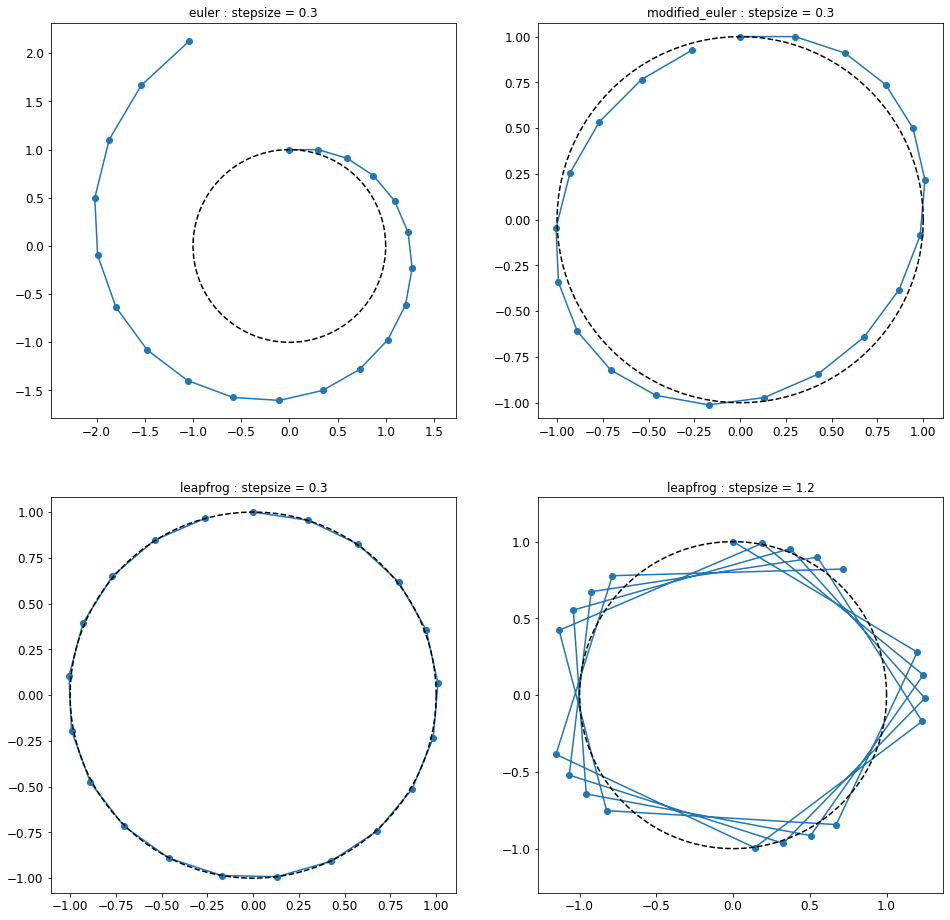

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

solve_and_plot_trajectory(axes[0, 0], q_initial, p_initial, q_exact, p_exact, grad_U, epsilon=0.3, L=20, method="euler")
solve_and_plot_trajectory(axes[0, 1], q_initial, p_initial, q_exact, p_exact, grad_U, epsilon=0.3, L=20, method="modified_euler")
solve_and_plot_trajectory(axes[1, 0], q_initial, p_initial, q_exact, p_exact, grad_U, epsilon=0.3, L=20, method="leapfrog")
solve_and_plot_trajectory(axes[1, 1], q_initial, p_initial, q_exact, p_exact, grad_U, epsilon=1.2, L=20, method="leapfrog")